# CRBM usage


This notebook shows how to use `crbm_tools.py` with some details.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import inspect
import json
import pickle

import random
import numpy as np 
import pandas as pd
import numexpr as ne
import sklearn
from sklearn import preprocessing
from matplotlib import pyplot as plt 

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import tstools
from tstools import timeseries  

import Datasets
from Datasets import al_series

In [2]:
import CRBM
from CRBM import crbm_tools
from CRBM.crbm_tools import build_slices_from_list_of_arrays

In [3]:
#from path import path
my_path = '../Datasets/al_series/'

files = os.walk(my_path)

X = []

for root, dirs, files in files:
    for f in files:
        x = pd.read_csv(os.path.join(root, f), index_col="Unnamed: 0")
        X.append(x.values)

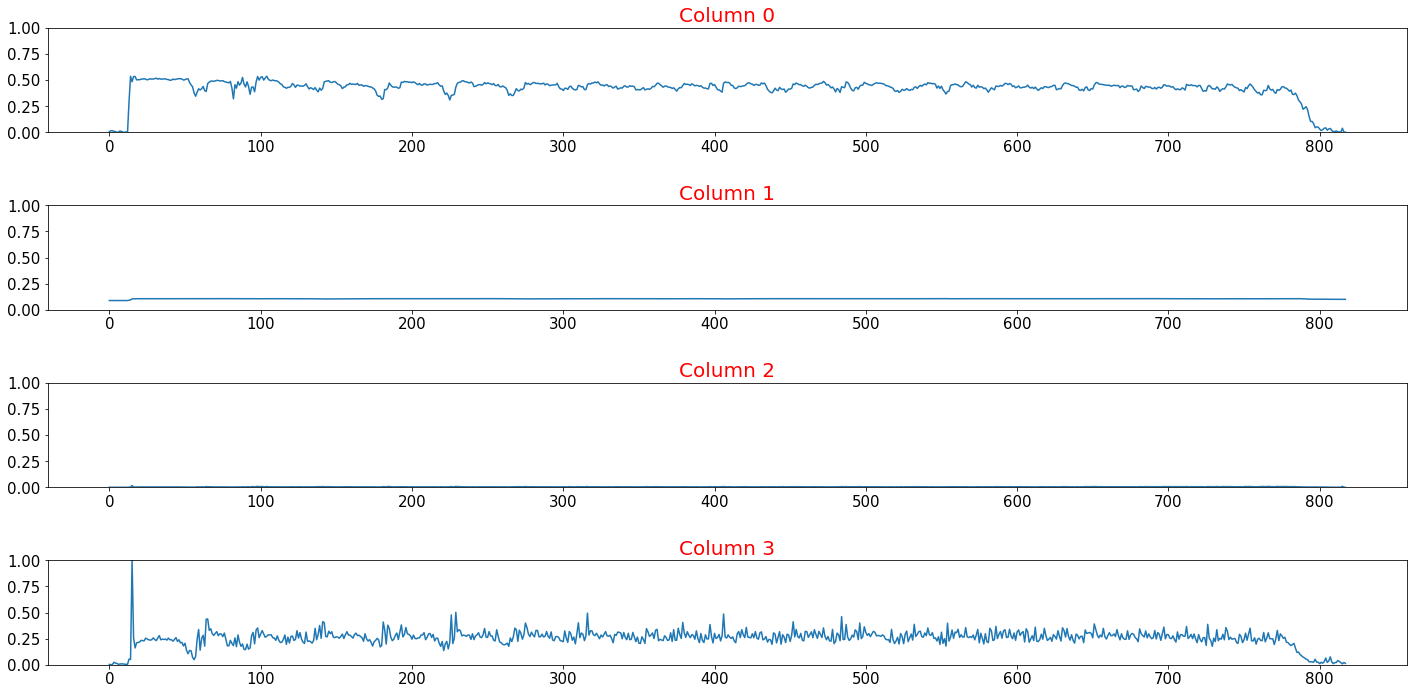

In [4]:
timeseries.plot_timeseries(X[-8])

In [5]:
X_train = X[0:-8]
X_test = X[-8:]
len(X_train), len(X_test),len(X)

(24, 8, 32)

In [6]:
n_feat = X_train[0].shape[1]
n_feat

4


### Generate train slices

We can create, given `n_vis` and `n_his`, a list containing all the slices of those proportions from our timeseries. This will be used for learning.

In [7]:
X_train[0].shape

(46, 4)

In [8]:
X_train[0][0:20].shape

(20, 4)

In [9]:
X_slices = build_slices_from_list_of_arrays(X_train, 20, n_feat)

In [322]:
len(X_slices)

22982

In [325]:
X_slices[0].shape

(21, 4)

### CRBM class

### Notes on the weight initialization

A relevant aspect of learning algorithms is the initial magnitude of the weights. It turns out that the magnitude of the weights in a layer can impact the net input of the layer above and this can lead to unnexpected error. In the case of the RBM the Bernoulli hidden units generate samples acording to a logistic. Since the logistic contains an exponential this can lead to numerical problems if the numbers in the exponential are big.

#### Scaling using a fixed min-max interval

In order to facilitate introducing the problem we can start with a concrete example and generalize from there. Let us assume we have 500 visible units and 100 visible units. Let us consider a visible vector with values between 
0 and 1. Then the net input of hidden unit $i$ will be

$$
z_i = {\boldsymbol W_i} \cdot {\boldsymbol  x} + b_i
$$

If we  initialize ${\boldsymbol W_i} $ to have values in $[-0.5, 0.5]$  and $b_i=0$ then 

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq 0.5 * 1 + \dots 0.5 * 1 = 500*0.5 = 250
$$

In the worst case scenario when computing the sigmoid of that value we will have:

$$
   a_i = \frac{1}{1 + \text{e}^{-250}}
$$

We can easily run into numerical problems for the exponential of a number with "big magnitude".

#### Scaling taking into acount the number of units in the layers

Let us consider the same example as above but where we scale the weights by the maximum of the number of hidden units and visible units. In this case 500. Now all of a sudden

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq \frac{0.5}{500}  1 + \dots \frac{0.5}{500}  1 = 500 \cdot \frac{0.5}{500} = 0.5
$$

What whould happen now if we conside that we have an input layer with 100000 units? Well the maximum net input of the initial weights is ensured to be equal to the maximum value achievable in the input feature space.

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq \frac{0.5}{100000 }  1 + \dots \frac{0.5}{100000 }  1 = 100000  \cdot \frac{0.5}{100000} = 0.5
$$



In [11]:
n_his = 20
n_hid = 256

In [12]:
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=n_hid, n_his=n_his, seed=123, sigma = 0.3);

In [13]:
#crbm.save("./saved_model_test", "crbm_")

In [14]:
#saved_crbm = CRBM.load("./saved_model_test/crbm_not_trained/")

### Auxiliary functions

In [15]:
from CRBM.crbm_tools import split_vis

In [16]:
crbm

In [17]:
X1 = X_train[0][0:(n_his+1), :]
X1.shape, crbm.n_his

((21, 4), 20)

In [18]:
vis, cond = split_vis(crbm, X1)
vis.shape, cond.shape

((4, 1), (4, 20))

### Gradient computation

In [329]:
aux = np.array([[1,2,3,4,5,6,7,8,9,10,11,12]])

In [332]:
crbm_tools.history_mat_to_vec(aux)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

In [19]:
X = X1[0:21,:]

In [20]:
X.shape, crbm.n_his, crbm.n_vis

((21, 4), 20, 4)

In [21]:
X.shape

(21, 4)

In [22]:
# Notice that the history is converted to a "long column vector" concatenating
# all the rows of the n_his vectors into a single vector of `n_vis * n_his` elements.
# This is done by `cond = np.array([cond.flatten()]).T`

dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X)

In [23]:
X.shape, rec_error

((21, 4), 0.06771565122833738)

In [24]:
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
learning_rate = 0.001
#import pdb;pdb.set_trace()

for i in range(10):
    dW, dA, dB, dv_bias, dh_bias, err = crbm_tools.compute_gradient(crbm, X)
    grads  = (dW, dA, dB, dv_bias, dh_bias)
    crbm_tools.update_weights_sgd(crbm, grads,  learning_rate)
    print("reconstruction error:", err)

reconstruction error: 0.06771565122833738
reconstruction error: 0.06331313524107479
reconstruction error: 0.05919684926523522
reconstruction error: 0.05534818080200232
reconstruction error: 0.05174973228394073
reconstruction error: 0.0483852369618805
reconstruction error: 0.04523948088299942
reconstruction error: 0.04229824447780483
reconstruction error: 0.03954822979151418
reconstruction error: 0.03697700688142105


### SGD Minibatch

In [25]:
X.shape, crbm.n_his

((21, 4), 20)

In [26]:
X.shape

(21, 4)

### Apply momentum

In [27]:
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

for i in range(10):
    dW, dA, dB, dv_bias, dh_bias, err = crbm_tools.compute_gradient(crbm, X)
    grads  = (dW, dA, dB, dv_bias, dh_bias)
    crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.2)
    print("reconstruction error:", err)

reconstruction error: 0.06771565122833738
reconstruction error: 0.06331313524107479
reconstruction error: 0.058316345493135587
reconstruction error: 0.053525563928314944
reconstruction error: 0.04908745528534913
reconstruction error: 0.045008421749723256
reconstruction error: 0.04126639874249363
reconstruction error: 0.03783506350528225
reconstruction error: 0.034688951946278156
reconstruction error: 0.03180442826900578


### Get slice of data

Given a timeseries where column `k` corresponds to a feature vector for the measurements of the timeseries at time `k`, we would like to take a slice of `n_his` values to feed the CRBM with a visible vector and a history.

In [28]:
X.shape

(21, 4)

In [29]:
X_tr = X_train[0].T
print("X_tr shape: ", X_tr.shape, "\nslice shape:", crbm_tools.get_slice_at_position_k(X_tr, 25, crbm.n_his).shape)

X_tr shape:  (4, 46) 
slice shape: (4, 21)


### Train some  epochs 

#### Without momentum


In [327]:
%%time
crbm_test = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 1
learning_rate = 0.001 # we have increased the  learning rate

for n in range(n_epochs):
    err_epoch = 0
    iters = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm_test, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        crbm_tools.update_weights_sgd(crbm_test, grads,  learning_rate)
        iters +=1
        err_epoch += rec_error
    
    print("ep {} => rec error: ".format(n), err_epoch/iters)#, end="\r")

ep 0 => rec error:  0.029389045114354848
CPU times: user 21.6 s, sys: 633 ms, total: 22.2 s
Wall time: 12.1 s


#### With momentum


In [31]:
len(X_slices), X_slices[0].shape

(22982, (21, 4))

In [46]:
%%time
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 10
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

all_errors = []
error_per_epoch = []

for n in range(n_epochs):
    iters = 0
    err_epoch = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        all_errors.append(rec_error)
        crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.01)
        iters +=1
        err_epoch += rec_error
        
    error_per_epoch.append(err_epoch)
    
    print(f"iter: {n} rec error: {err_epoch}") #, end="\r")

iter: 0 rec error: 673.9263779355854
iter: 1 rec error: 630.8532942396247
iter: 2 rec error: 600.6502226427766
iter: 3 rec error: 579.2336924936918
iter: 4 rec error: 563.6086282304688
iter: 5 rec error: 551.7412755953297
iter: 6 rec error: 542.361362706052
iter: 7 rec error: 534.6187826172517
iter: 8 rec error: 527.9808258334077
iter: 9 rec error: 522.1307053750784
CPU times: user 4min 35s, sys: 10.8 s, total: 4min 45s
Wall time: 2min 45s


In [50]:
#plt.plot(rec_error_per_epoch)
#plt.hlines(0.02, xmin=0, xmax=50, linestyles="--")

In [51]:
import time

In [56]:
t0 =time.time() 


In [83]:
%%time
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 50
learning_rate = 0.001

ctx = {"W_vel" : np.zeros(crbm.W.shape), 
       "A_vel" : np.zeros(crbm.A.shape),
       "B_vel" : np.zeros(crbm.B.shape), 
       "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
       "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

all_errors = []
error_per_epoch = []

t0 = time.time()
for n in range(n_epochs):
    iters = 0
    err_epoch = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        all_errors.append(rec_error)
        crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.5)
        iters +=1
        err_epoch += rec_error
    
    error_per_epoch.append(err_epoch)
    total_time = (time.time() - t0)/60
    print(f"iter: {n:3} rec error: {round(err_epoch,2):6}  train time {round(total_time, 2):5}  min") #, end="\r")

iter:   0 rec error: 595.58  train time  0.22  min
iter:   1 rec error:  574.6  train time  0.49  min
iter:   2 rec error: 559.18  train time  0.71  min
iter:   3 rec error: 546.31  train time  0.98  min
iter:   4 rec error: 535.29  train time   1.2  min
iter:   5 rec error: 525.82  train time  1.43  min
iter:   6 rec error:  517.7  train time  1.66  min
iter:   7 rec error: 510.74  train time   1.9  min
iter:   8 rec error: 504.77  train time  2.19  min
iter:   9 rec error:  499.6  train time  2.46  min
iter:  10 rec error: 495.05  train time  2.67  min
iter:  11 rec error: 490.99  train time  2.87  min
iter:  12 rec error:  487.3  train time  3.08  min
iter:  13 rec error:  483.9  train time  3.28  min
iter:  14 rec error: 480.73  train time  3.51  min
iter:  15 rec error: 477.76  train time  3.73  min
iter:  16 rec error: 474.97  train time  3.93  min
iter:  17 rec error: 472.35  train time  4.13  min
iter:  18 rec error: 469.87  train time  4.33  min
iter:  19 rec error: 467.54  tr

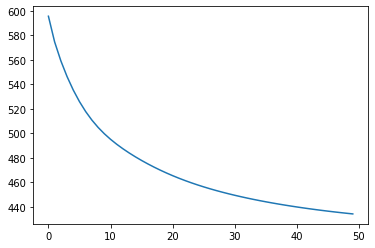

In [136]:
plt.plot(error_per_epoch)
#plt.plot([np.mean(all_errors[i:i+10000]) for i in range(0,len(all_errors),10000 )])

In [137]:
n_epochs = 100
learning_rate = 0.001

ctx = {"W_vel" : np.zeros(crbm.W.shape), 
       "A_vel" : np.zeros(crbm.A.shape),
       "B_vel" : np.zeros(crbm.B.shape), 
       "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
       "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

all_errors = []
error_per_epoch = []

t0 = time.time()
for n in range(n_epochs):
    iters = 0
    err_epoch = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        all_errors.append(rec_error)
        crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.5)
        iters +=1
        err_epoch += rec_error
    
    error_per_epoch.append(err_epoch)
    total_time = (time.time() - t0)/60
    print(f"iter: {n:3} rec error: {round(err_epoch,2):6}  train time {round(total_time, 2):5}  min") #, end="\r")

iter:   0 rec error:  433.6  train time  0.32  min
iter:   1 rec error:  433.1  train time  0.68  min
iter:   2 rec error: 432.63  train time  1.07  min
iter:   3 rec error: 432.17  train time  1.33  min
iter:   4 rec error: 431.74  train time  1.57  min
iter:   5 rec error: 431.32  train time  1.82  min
iter:   6 rec error: 430.92  train time  2.05  min
iter:   7 rec error: 430.52  train time  2.29  min
iter:   8 rec error: 430.14  train time   2.6  min
iter:   9 rec error: 429.78  train time  2.91  min
iter:  10 rec error: 429.42  train time  3.21  min
iter:  11 rec error: 429.07  train time  3.45  min
iter:  12 rec error: 428.73  train time  3.72  min
iter:  13 rec error:  428.4  train time  3.97  min
iter:  14 rec error: 428.08  train time   4.2  min
iter:  15 rec error: 427.76  train time  4.43  min
iter:  16 rec error: 427.45  train time  4.72  min
iter:  17 rec error: 427.14  train time  4.95  min
iter:  18 rec error: 426.84  train time  5.18  min
iter:  19 rec error: 426.55  tr

In [139]:
crbm.save("./saved_models", "crbm_150_epochs_mom_0d5_lr_0d001")

The model crbm_150_epochs_mom_0d5_lr_0d001 inside folder ./saved_models/crbm_150_epochs_mom_0d5_lr_0d001 already exists!


0

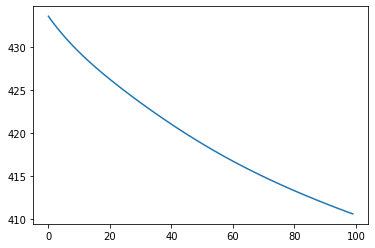

In [293]:
plt.plot(error_per_epoch)

In [295]:
n_epochs = 300
learning_rate = 0.001

ctx = {"W_vel" : np.zeros(crbm.W.shape), 
       "A_vel" : np.zeros(crbm.A.shape),
       "B_vel" : np.zeros(crbm.B.shape), 
       "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
       "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

all_errors = []
#error_per_epoch = []

t0 = time.time()
for n in range(n_epochs):
    iters = 0
    err_epoch = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        all_errors.append(rec_error)
        crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.5)
        iters +=1
        err_epoch += rec_error
    
    error_per_epoch.append(err_epoch)
    total_time = (time.time() - t0)/60
    print(f"iter: {n:3} rec error: {round(err_epoch,2):6}  train time {round(total_time, 2):5}  min", end="\r")

In [301]:
crbm.save("./saved_models", "crbm_450_epochs_mom_0d5_lr_0d001")

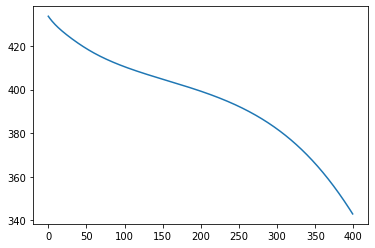

In [302]:
plt.plot(error_per_epoch)

### Randomize examples

```
%%time
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 50
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

rec_error_per_epoch = []
n_samples = len(X_slices)

for n in range(n_epochs):
    err_epoch = 0
    random.shuffle(X_slices)
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.1)
        err_epoch += rec_error
        
    rec_error_per_epoch.append(err_epoch/n_samples)
    print("ep {} => rec error: ".format(n), err_epoch/n_samples,end="\r")
    ```

%%time
crbm = crbm_tools.CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 50
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

rec_error_per_epoch = []
n_samples = len(X_slices)

for n in range(n_epochs):
    err_epoch = 0
    random.shuffle(X_slices)
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = crbm_tools.compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        crbm_tools.update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.1)
        err_epoch += rec_error
        
    rec_error_per_epoch.append(err_epoch/n_samples)
    print("ep {} => rec error: ".format(n), err_epoch/n_samples,end="\r")

In [ ]:
## save the model
#crbm.save("./saved_models", "crbm_50_epochs")

In [ ]:
#plt.plot(rec_error_per_epoch)

### Make predictions with the model

#### Get data

In [142]:
X_tr = X_train[0].T
print("X_tr shape: ", X_tr.shape, "\nslice shape:", crbm_tools.get_slice_at_position_k(X_tr, 25, crbm.n_his).shape)

X_tr shape:  (4, 46) 
slice shape: (4, 21)


### Evaluate the model making predictions given the first values of the trace

In [320]:
m = 8
X_tr = X_train[m].T

first visible vector at position:  31
(4, 20) 4 (4, 1) (4, 20) (21, 4)
(4, 1) (80, 1) 4 (4, 80) (256, 80) (256, 4)
1.0 1.0
shapes: (458, 4) (458, 4)
MSE: 0.5162394801956531


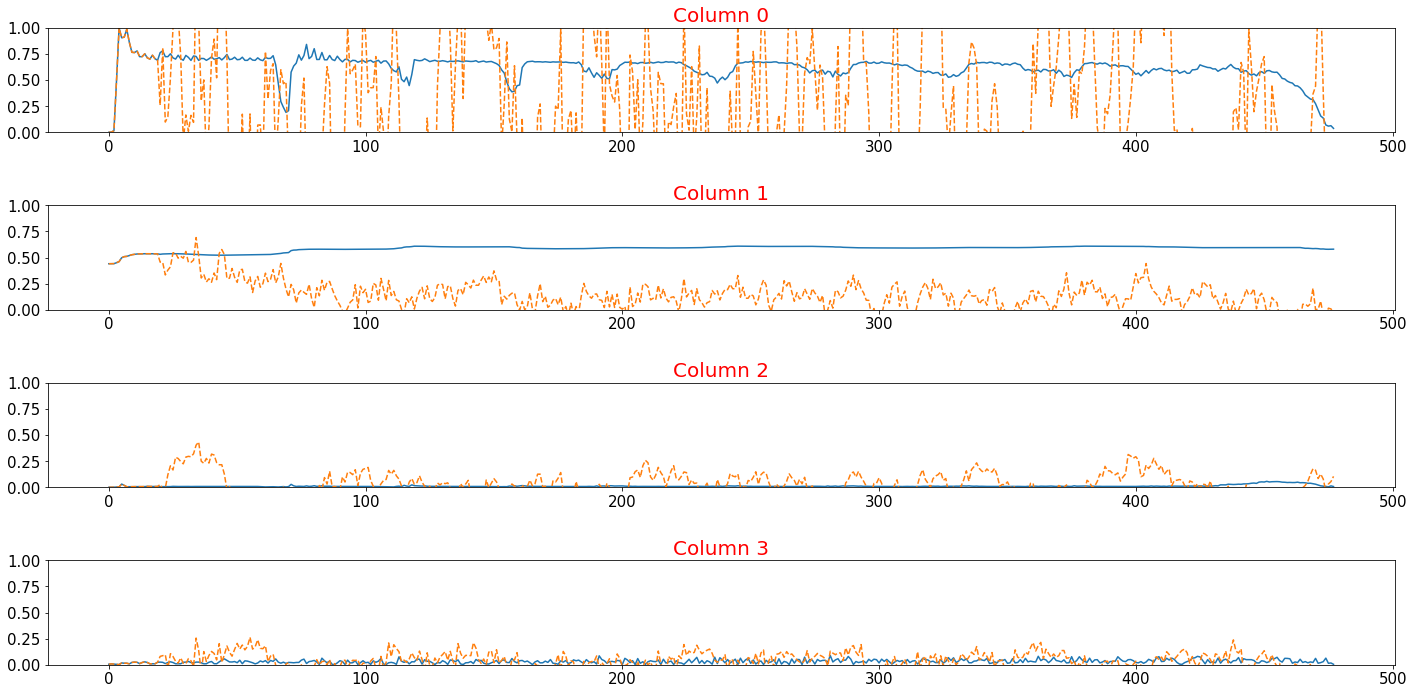

In [321]:
start_pos = 10
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                         # first visible vector
hist_and_v  = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond     = crbm_tools.split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  crbm_tools.history_mat_to_vec(cond)

print("first visible vector at position: ", start_pos + crbm.n_his+1)
print(cond.shape, crbm.n_vis,  v.shape, cond.shape, X.shape)
print(v.shape, cond_as_vec.shape, crbm.n_vis, crbm.A.shape, crbm.B.shape, crbm.W.shape)
print(cond.max(), cond_as_vec.max())

n_samples = X_tr.shape[1] - crbm.n_his
samples = crbm_tools.generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples, n_gibbs=5)
y_true  = X_tr[:, crbm.n_his:n_samples].T
y_hat   = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]

print("shapes:", y_hat.shape, y_true.shape)
print("MSE:", np.sqrt(np.mean((y_hat - y_true)**2)))

timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)), np.vstack((cond.T, y_hat)))

first visible vector at position:  21
(4, 20) 4 (4, 1) (4, 20) (21, 4)
(4, 1) (80, 1) 4 (4, 80) (256, 80) (256, 4)
0.561093270779 0.561093270779
shapes: (1120, 4) (1120, 4)
MSE: 0.27919357159905156


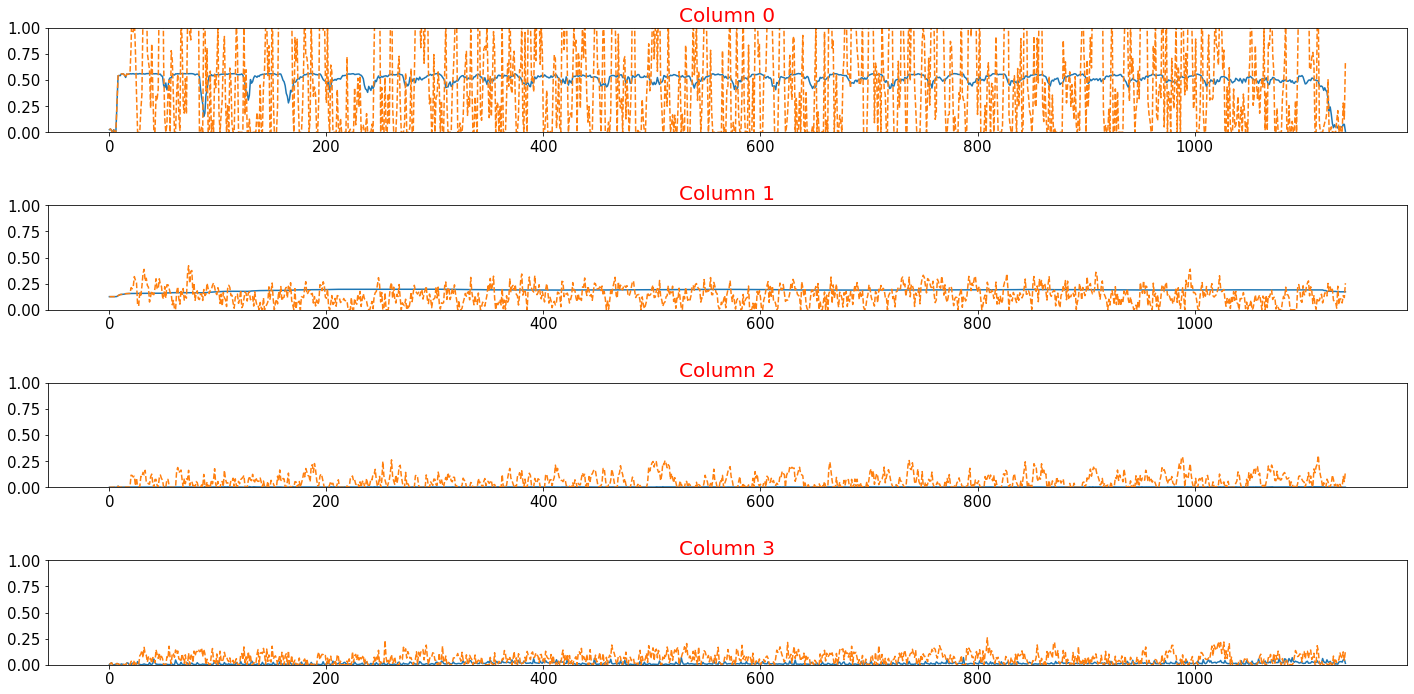

In [306]:
start_pos = 0
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                          # first visible vector
hist_and_v  = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond     = crbm_tools.split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  crbm_tools.history_mat_to_vec(cond)

print("first visible vector at position: ", start_pos + crbm.n_his+1)
print(cond.shape, crbm.n_vis,  v.shape, cond.shape, X.shape)
print(v.shape, cond_as_vec.shape, crbm.n_vis, crbm.A.shape, crbm.B.shape, crbm.W.shape)
print(cond.max(), cond_as_vec.max())

n_samples = X_tr.shape[1] - crbm.n_his
samples = crbm_tools.generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples, n_gibbs=25)
y_true = X_tr[:, crbm.n_his:n_samples].T
y_hat = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]

print("shapes:", y_hat.shape, y_true.shape)
print("MSE:", np.sqrt(np.mean((y_hat - y_true)**2)))

timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)),np.vstack((cond.T, y_hat)))


Compute the mean 

##### Investigate how history is passed when training and how history is updated at prediction time

In [ ]:
start_pos = 0
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                          # first visible vector
hist_and_v  = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond     = crbm_tools.split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  crbm_tools.history_mat_to_vec(cond)

print("first visible vector at position: ", start_pos + crbm.n_his+1)
print(cond.shape, crbm.n_vis,  v.shape, cond.shape, X.shape)
print(v.shape, cond_as_vec.shape, crbm.n_vis, crbm.A.shape, crbm.B.shape, crbm.W.shape)
print(cond.max(), cond_as_vec.max())

n_samples = X_tr.shape[1] - crbm.n_his
samples = crbm_tools.generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples, n_gibbs=15)
y_true = X_tr[:, crbm.n_his:n_samples].T
y_hat = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]

print("shapes:", y_hat.shape, y_true.shape)
print("MSE:", np.sqrt(np.mean((y_hat - y_true)**2)))

timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)),np.vstack((cond.T, y_hat)))

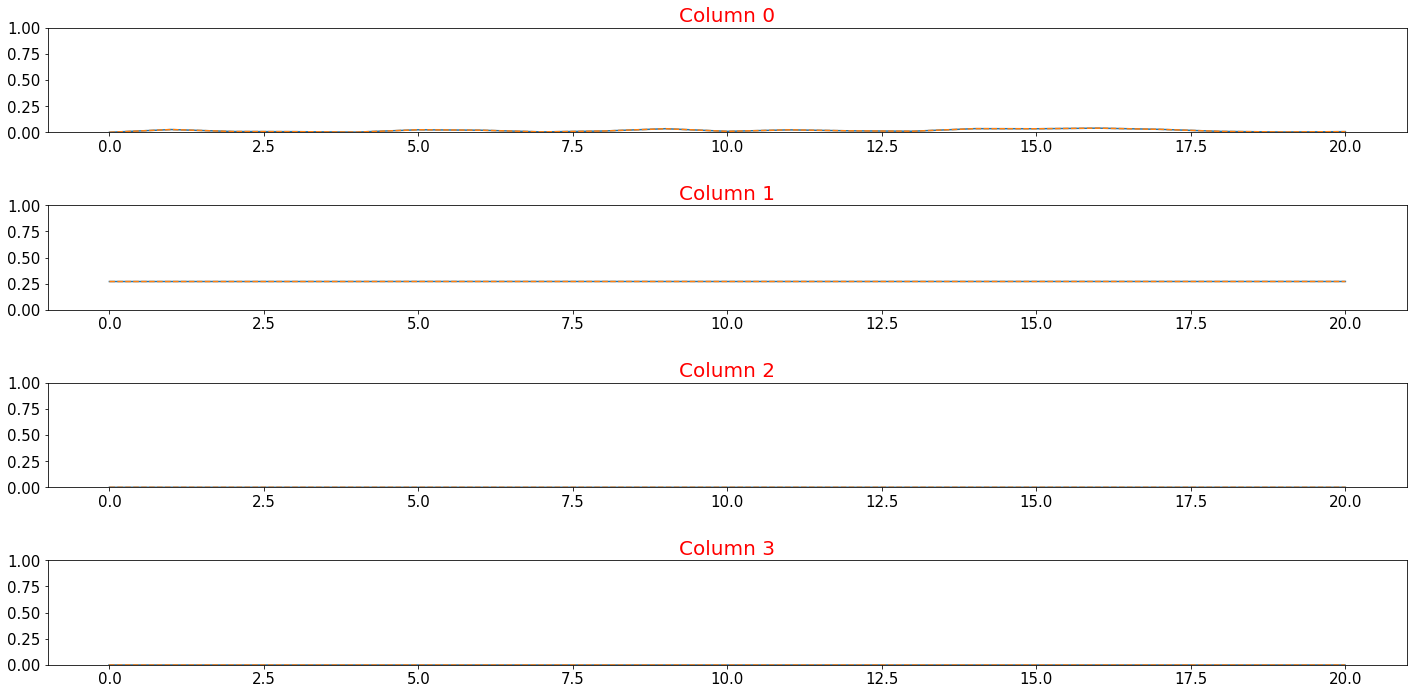

In [257]:
m = 9000
timeseries.plot_timeseries_overlaped(X_slices[m],X_slices[m])

In [272]:
np.mean([x[:,0] for x in X_slices])

0.18000218353262698

In [276]:
np.mean([x[:,3] for x in X_slices])

0.014227510166997172

### Fer mitjana de les prediccions

In [89]:
n_predictions = 30
start_pos = 0

In [90]:
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                         # first visible vector
hist_and_v = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond = crbm_tools.split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  crbm_tools.history_mat_to_vec(cond)

In [91]:
%%time
predictions = []
for i in range(n_predictions):
    cond_as_vec =  crbm_tools.history_mat_to_vec(cond)
    samples = crbm_tools.generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples, n_gibbs=1)
    y_hat = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]
    predictions.append(y_hat)

CPU times: user 4.97 s, sys: 102 ms, total: 5.08 s
Wall time: 2.58 s


In [92]:
y_hat_mean = np.array(predictions).mean(axis=0)

In [93]:
# We can impose that features below 0 take value 0 since all our data is scaled in the [0,1] range
y_hat_mean[y_hat_mean<0] = 0

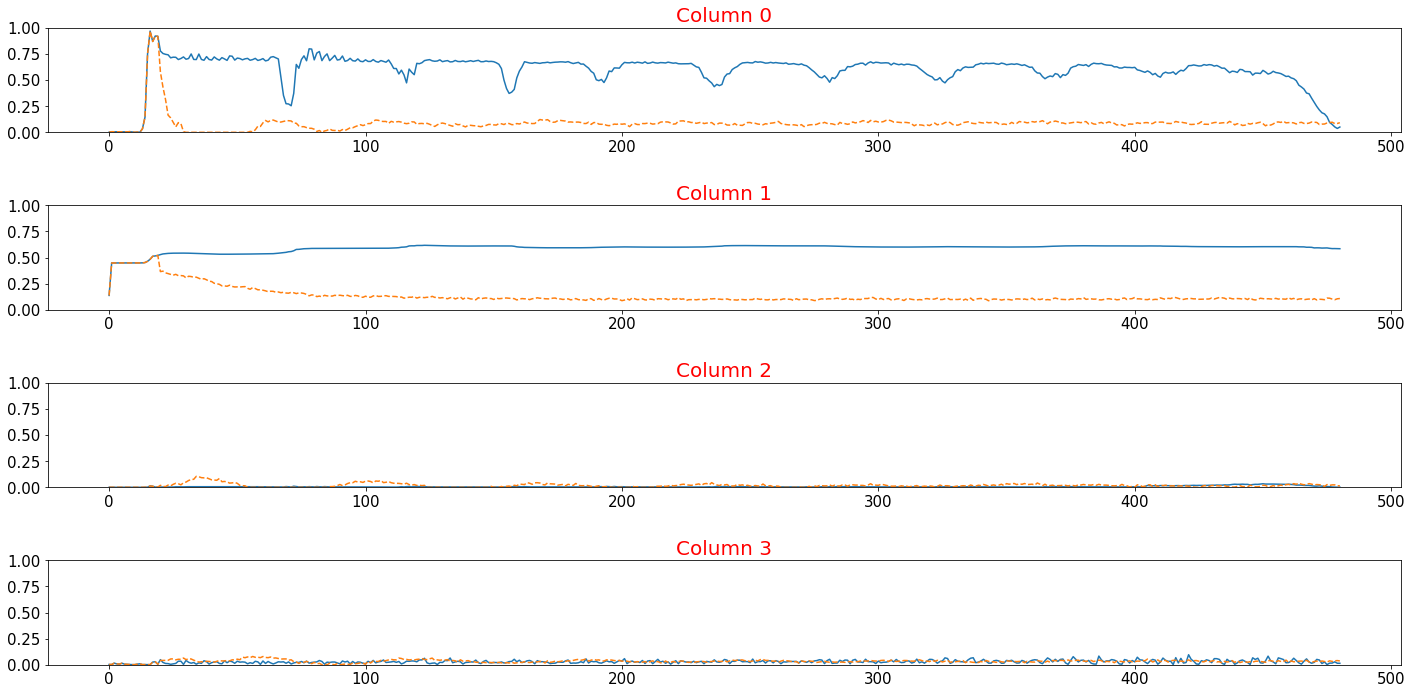

In [94]:
timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)),np.vstack((cond.T, y_hat_mean)))

In [284]:
np.mean(y_hat_mean - y_true)

-0.092977433674154536

### Persistent chain for predictions

In [ ]:

def split_vis_rowdata(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[0:(n_his-1), :].T
    x = vis[[n_his-1],:].T
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond




def split_vis_coldata(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[:, 0:(n_his-1)]
    x = vis[[n_his-1],:]
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond

#### Making predictions with persistent chain

Prepare an example that trains with several data and predict feature values

```
forecast_crbm <- forecast.crbm <- function(crbm, orig_data, orig_history = NULL, n_samples = 10, n_gibbs = 30)
{
	if (is.null(orig_history))
	{
		l <- nrow(orig_data);
		orig_history <- orig_data[l - 1:crbm$delay,, drop=FALSE];
		orig_history <- array(t(orig_history), c(1, crbm$n_visible * crbm$delay));
		orig_data <- orig_data[l,, drop = FALSE];
		n_seq <- 1;
	} else {
		n_seq <- nrow(orig_data);
	}
	
	persistent_vis_chain <<- orig_data;
	persistent_history <<- orig_history;

    # construct the function that implements our persistent chain.
	sample_fn <- function(crbm, n_gibbs)
	{
		vis_sample <- persistent_vis_chain;
		v_history <- persistent_history;

		vis_mf <- NULL;
		for (k in 1:n_gibbs)
		{
			hid <- sample_h_given_v_crbm(crbm, vis_sample, v_history);
			vis <- sample_v_given_h_crbm(crbm, hid[["sample"]], v_history);

			vis_mf <- vis[["mean"]];
			vis_sample <- vis[["sample"]];
		}

		# add to updates the shared variable that takes care of our persistent chain
		persistent_vis_chain <<- vis_sample;
		persistent_history <<- cbind(vis_sample, persistent_history[,1:((crbm$delay - 1) * crbm$n_visible), drop = FALSE]);

		vis_mf;
	}

	generated_series <- array(0,c(n_seq, n_samples, crbm$n_visible));
	for (t in 1:n_samples)
	{
		#if (t %% 10 == 1) print(paste("Generating frame ", t, " to ", min(t+9, n_samples), sep = ""));
		generated_series[,t,] <- sample_fn(crbm, n_gibbs);
	}
	generated_series;
}
```

In [ ]:
def generate_persistent(crbm, orig_data, orig_hist, n_samples, n_gibbs=10):
    """ 
    Given initialization(s) of visibles and matching history, generate n_samples in future.
    
        orig_data : n_seq by n_visibles array
            initialization for first frame
            
        orig_history : n_seq by delay * n_visibles array
            delay-step history
            
        n_samples : int
            number of samples to generate forward
            
        n_gibbs : int
            number of alternating Gibbs steps per iteration
    """
    n_seq = orign_data.shape[0]
    persistent_vis_chain = None
    persistent_history   = None
    
    return generated_series

### Plot predictions